In [222]:
%pip install spectral

Note: you may need to restart the kernel to use updated packages.


In [223]:
import hytools.masks.cloud

# Define a function to override the original `zhai_cloud`
def patched_zhai_cloud(hy_obj, cloud, shadow, T1=0.01, t2=.1, t3=.25, t4=.5, T7=9, T8=9):
    blue = hy_obj.get_wave(444)   # New wavelength
    green = hy_obj.get_wave(560)  # New wavelength
    red = hy_obj.get_wave(650)    # New wavelength
    nir = hy_obj.get_wave(862)    # New wavelength
    
    # Call the original function but with modified parameters
    return hytools.masks.cloud.zhai_cloud(hy_obj, cloud, shadow, T1, t2, t3, t4, T7, T8)

# Patch the function in the `hytools.masks.cloud` module
hytools.masks.cloud.zhai_cloud = patched_zhai_cloud

# Now, when `zhai_cloud()` is called from `hytools`, it will use the modified version


In [224]:
import hytools as ht
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import nbconvert
import time
import os


In [225]:
os.getcwd()

'/home/jovyan/data-store/cross-sensor-cal'

In [226]:
%load_ext autoreload
%autoreload 2

import drone_spectral_unmixing_tools_original as el_spectral

print(dir(el_spectral))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'drone_spectral_unmixing_tools_original'

In [246]:
data_dir = '/home/jovyan/data-store/cross-sensor-cal/data_set2'
file_path = os.path.join(data_dir,'aligned_orthomosaic.tif')
slope_path = os.path.join(data_dir,'aligned_slope.tif')
aspect_path = os.path.join(data_dir,'aligned_aspect.tif')
chm_path = os.path.join(data_dir,'aligned_chm.tif')

date_time_str = '2023-08-16 18:53:18'
chm_path

'/home/jovyan/data-store/cross-sensor-cal/data_set2/aligned_chm.tif'

In [247]:
from osgeo import gdal, osr
import re
from typing import Union
import h5py
import numpy as np
import os

# Define Wavelengths and Full Width at Half Maximum (FWHM) for spectral bands
wavelengths = [444, 475, 531, 560, 650, 668, 705, 717, 740, 862]  # In nm
fwhm = [28, 32, 14, 27, 16, 14, 10, 12, 18, 57]

def create_h5_file_from_dict(data, h5_file, group_name="/"):
    """Recursively create groups and datasets in an HDF5 file from a dictionary."""
    for key, value in data.items():
        if isinstance(value, dict):
            subgroup_name = f"{group_name}/{key}"
            _ = h5_file.create_group(subgroup_name)
            create_h5_file_from_dict(value, h5_file, subgroup_name)
        else:
            dataset_name = f"{group_name}/{key}"
            if os.path.basename(group_name) == 'Coordinate_System':
                dataset = h5_file.create_dataset(dataset_name, data=str(value), dtype=h5py.string_dtype())
            else:
                dataset = h5_file.create_dataset(dataset_name, data=value)
            if key in ['Wavelength', 'FWHM']:
                dataset.attrs['Units'] = 'nanometers'

def remove_non_numeric(input_string):
    """Remove non-numeric characters from a string."""
    return re.sub(r'\D', '', input_string)

def load_data(data: Union[str, np.array], expected_shape):
    """Loads data from file or ensures an array has the expected shape."""
    if isinstance(data, str):
        data_array = gdal.Open(data).ReadAsArray()
    else:
        data_array = np.array(data)
    
    if data_array.shape != expected_shape:
        raise ValueError(f"Data shape mismatch: Expected {expected_shape}, but got {data_array.shape}")
    
    return data_array

def tiff_to_h5(reflectance_tiff_path: str, slope_data: Union[str, np.array],
               aspect_data: Union[str, np.array], path_length_data: Union[str, np.array],
               solar_zenith_data: Union[str, np.array], solar_azimuth_data: Union[str, np.array]):
    """Converts a TIFF reflectance file into an HDF5 format with metadata and ancillary data."""

    # Open reflectance TIFF
    reflectance_ds = gdal.Open(reflectance_tiff_path)
    reflectance_data = reflectance_ds.ReadAsArray()[:10, :, :]  # Use first 10 bands
    img_shape = reflectance_data.shape[1:]  # (rows, cols)

    # Load ancillary data
    slope_data = load_data(slope_data, img_shape)
    aspect_data = load_data(aspect_data, img_shape)
    path_length_data = load_data(path_length_data, img_shape)
    solar_zenith_data = load_data(solar_zenith_data, img_shape)
    solar_azimuth_data = load_data(solar_azimuth_data, img_shape)

    # Set sensor angles to zero matrices matching image shape
    sensor_zenith_data = np.zeros(img_shape)
    sensor_azimuth_data = np.zeros(img_shape)

    # Extract spatial metadata
    proj = reflectance_ds.GetProjection()
    geo_transform = reflectance_ds.GetGeoTransform()
    
    spatial_ref = osr.SpatialReference()
    spatial_ref.ImportFromWkt(proj)
    epsg_code = spatial_ref.GetAuthorityCode(None)

    utm_zone = int(remove_non_numeric(proj.split("UTM zone ")[1].split(",")[0])) if "UTM zone" in proj else None
    map_info_string = f"UTM, 1.000, 1.000, {geo_transform[0]:.3f}, {geo_transform[3]:.3f}, {geo_transform[1]:.3f}, {geo_transform[5]:.3f}, {utm_zone}, North, WGS-84, units=Meters, 0"

    # HDF5 Structure
    h5_data = {
        'NIWO': {
            'Reflectance': {
                'Metadata': {
                    'Coordinate_System': {
                        'Coordinate_System_String': proj,
                        'EPSG Code': epsg_code,
                        'Map_Info': map_info_string,
                        'Proj4': spatial_ref.ExportToProj4()
                    },
                    "Ancillary_Imagery": {
                        "Path_Length": path_length_data,  # Now uses raster-based path length
                        "Slope": slope_data,
                        "Aspect": aspect_data
                    },
                    "Logs": {
                        "Solar_Azimuth_Angle": solar_azimuth_data,
                        "Solar_Zenith_Angle": solar_zenith_data
                    },
                    "to-sensor_Azimuth_Angle": sensor_azimuth_data,
                    "to-sensor_Zenith_Angle": sensor_zenith_data,
                    "Spectral_Data": {
                        'FWHM': fwhm,
                        'Wavelength': wavelengths
                    }
                },
                'Reflectance_Data': np.transpose(reflectance_data, axes=(1, 2, 0))  # Convert to (rows, cols, bands)
            }
        }
    }

    # Save to HDF5
    h5_filename = os.path.join(data_dir,'NEON_D13_NIWO_' + os.path.basename(reflectance_tiff_path).replace('.tif', '.h5'))
    with h5py.File(h5_filename, "w") as hdf_file:
        create_h5_file_from_dict(h5_data, hdf_file)

    print(f"HDF5 file created: {h5_filename}")

In [248]:
import ephem
import rasterio
import numpy as np
from rasterio import Affine as A
from rasterio.warp import reproject, Resampling
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from osgeo import gdal
import seaborn as sns
import rasterio
from pyproj import Proj, transform
from rasterio.transform import from_origin
import ephem
import datetime
import math
import warnings

def pixel_to_coord(file_path):
     with rasterio.open(file_path) as src:
            band1 = src.read(1)
            print('Band1 has shape', band1.shape)
            height = band1.shape[0]
            width = band1.shape[1]
            cols, rows = np.meshgrid(np.arange(width), np.arange(height))
            xs, ys = rasterio.transform.xy(src.transform, rows, cols)
            eastings= np.array(xs)
            northings = np.array(ys)
            print('eastings shape', eastings.shape)
            p1 = Proj(src.crs)
            p2 = Proj(proj='latlong', datum='WGS84')
            lons, lats = transform(p1, p2, eastings, northings)
     return lons, lats, cols, rows,


file_path = file_path #r'/home/jovyan/data-store/cross-sensor-cal/data_set2/aligned_orthomosaic.tif'
longitudes, latitudes, cols, rows = pixel_to_coord(file_path)

# # # Function to convert lat/lon to row/col
# # def latlon_to_rowcol(transform, lat, lon):
# #     col, row = ~transform * (lon, lat)
# #     return int(row), int(col)

# Convert the date and time to UTC. The time given is 2:34 PM, which is 14:34 in 24-hour format
date_time_str = date_time_str #'2023-08-01 21:34:00'


with rasterio.open(file_path) as src:
    # Get the affine transform for the raster
    transform = src.transform
    
    # Create arrays to hold the azimuth and zenith values
    azimuth = np.zeros((src.height, src.width), dtype=np.float32)
    zenith = np.zeros((src.height, src.width), dtype=np.float32)
    
    # Assume a date and time for the Sun position calculation
    observer = ephem.Observer()
    observer.date = ephem.date(date_time_str)
    
    # Iterate over each pixel in the raster
    for row in range(latitudes.shape[0]):
        for col in range(latitudes.shape[1]):
            #lon, lat = pixel_to_coord(transform, row, col)
            observer.lat, observer.lon = latitudes[row,col], longitudes[row,col]
            
            sun = ephem.Sun(observer)
            
            # Convert azimuth and altitude (zenith angle is 90 - altitude) to degrees
            az = np.degrees(sun.az)
            #az = sun.az
            alt = np.degrees(sun.alt)
            zen = 90 - sun.alt
            
            azimuth[row, col] = az
            zenith[row, col] = zen



Band1 has shape (835, 1179)
eastings shape (835, 1179)


In [249]:
tiff_to_h5(file_path, slope_path, aspect_path, chm_path, zenith, azimuth)
print("6")

HDF5 file created: /home/jovyan/data-store/cross-sensor-cal/data_set2/NEON_D13_NIWO_aligned_orthomosaic.h5
6


In [231]:
NEON_image_path = '/home/jovyan/data-store/cross-sensor-cal/NEON_D13_NIWO_aligned_orthomosaic.h5'
output_dir = '/home/jovyan/data-store/cross-sensor-cal/output'

In [232]:
import os
print(os.path.exists(NEON_image_path))  # Should return True
print(os.path.isdir(output_dir))  # Should return True


True
True


In [233]:
import subprocess
import os

neon_script = os.path.abspath("neon2envi2_generic.py")  # Get absolute path
print(f"Using script: {neon_script}")

Using script: /home/jovyan/data-store/cross-sensor-cal/neon2envi2_generic.py


In [234]:
import subprocess
import os

def process_hdf5_with_neon2envi(image_path, output_dir):
    """
    Runs the modified neon2envi2_generic.py script.
    """
    # Ensure we're using the correct Python script
    neon_script = os.path.abspath("neon2envi2_generic.py")  # Get absolute path
    print(f"Using script: {neon_script}")

    # Define the command
    command = [
        "/opt/conda/envs/macrosystems/bin/python", neon_script,
        "-anc",
        "--images", image_path,
        "--output_dir", output_dir
    ]

    print("Executing command:", " ".join(command))  # Debugging line

    try:
        with subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True) as proc:
            for line in proc.stdout:
                print(line, end='')  # Print output as it's received
    except subprocess.CalledProcessError as e:
        print(f"Error executing command: {e}")

In [235]:
process_hdf5_with_neon2envi(NEON_image_path, output_dir)
print('done')

Using script: /home/jovyan/data-store/cross-sensor-cal/neon2envi2_generic.py
Executing command: /opt/conda/envs/macrosystems/bin/python /home/jovyan/data-store/cross-sensor-cal/neon2envi2_generic.py -anc --images /home/jovyan/data-store/cross-sensor-cal/NEON_D13_NIWO_aligned_orthomosaic.h5 --output_dir /home/jovyan/data-store/cross-sensor-cal/output
2025-01-30 05:41:31,284	WARNING services.py:1996 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2025-01-30 05:41:32,421	INFO worker.py:1673 -- Started a local Ray instance.
Here we GO!

Exporting ancillary data
(HyTools pid=10874) Exported NEON_D13_NIWO

In [236]:
directory = '/home/jovyan/data-store/cross-sensor-cal/output/NEON_D13_NIWO_aligned_orthomosaic'

In [237]:
import json
import glob
import numpy as np
import os

# Define your configuration settings
bad_bands = []
file_type = 'envi'
directory = directory
main_image_name = os.path.basename(directory)
main_image_file = os.path.join(directory, main_image_name )  # Assuming the main image file has .h5 extension

# Glob pattern to find ancillary files within the same directory
anc_files_pattern = os.path.join(directory, "*_ancillary*")
anc_files = glob.glob(anc_files_pattern)
anc_files.sort()

aviris_anc_names = ['path_length', 'sensor_az', 'sensor_zn', 'solar_az', 'solar_zn',  'slope', 'aspect', 'phase', 'cosine_i']

suffix_labels = ["reflectance", "anc"]  # Define suffixes for different types of files

# Loop through each ancillary file and create a separate config file
for i, anc_file in enumerate(anc_files):
    if i == 0:
        suffix_label = f"_reflectance"
    elif i == 1:
        suffix_label = f"_anc"
    else:
        suffix_label = f"_{i}"  # Fallback for unexpected 'i' values

    
    
    config_dict = {}

    config_dict['bad_bands'] = bad_bands
    config_dict['file_type'] = file_type
    config_dict["input_files"] = [main_image_file]
    
    config_dict["anc_files"] = {
        main_image_file: dict(zip(aviris_anc_names, [[anc_file, a] for a in range(len(aviris_anc_names))]))
    }

    # Export settings
    config_dict['export'] = {}
    config_dict['export']['coeffs'] = True
    config_dict['export']['image'] = True
    config_dict['export']['masks'] = True
    config_dict['export']['subset_waves'] = []
    config_dict['export']['output_dir'] = os.path.join(directory)
    config_dict['export']["suffix"] = suffix_label



    # Detailed settings for export options, TOPO and BRDF corrections
    # These settings include parameters like the type of correction, calculation and application of masks, 
    # coefficients to be used, output directory, suffixes for output files, and various specific parameters 
    # for TOPO and BRDF correction methods.
    # Input format: Nested dictionaries with specific keys and values as per the correction algorithm requirements
    # Example settings include:
    # - 'export': Dictionary of export settings like coefficients, image, masks, output directory, etc.
    # - 'topo': Dictionary of topographic correction settings including types, masks, coefficients, etc.
    # - 'brdf': Dictionary of BRDF correction settings including solar zenith type, geometric model, volume model, etc.

    # Additional settings can be added as needed for specific correction algorithms and export requirements.

    # TOPO Correction options
    config_dict["corrections"] = ['topo','brdf']
    config_dict["topo"] =  {}
    config_dict["topo"]['type'] = 'scs+c'
    config_dict["topo"]['calc_mask'] = [["ndi", {'band_1': 862,'band_2': 668,
                                                'min': 0.1,'max': 1.0}],
                                        ['ancillary',{'name':'slope',
                                                    'min': np.radians(5),'max':'+inf' }],
                                        ['ancillary',{'name':'cosine_i',
                                                    'min': 0.12,'max':'+inf' }]]

    config_dict["topo"]['apply_mask'] = [["ndi", {'band_1': 862,'band_2': 668,
                                                'min': 0.1,'max': 1.0}],
                                        ['ancillary',{'name':'slope',
                                                    'min': np.radians(5),'max':'+inf' }],
                                        ['ancillary',{'name':'cosine_i',
                                                    'min': 0.12,'max':'+inf' }]]
    config_dict["topo"]['c_fit_type'] = 'nnls'

    # config_dict["topo"]['type'] =  'precomputed'
    # config_dict["brdf"]['coeff_files'] =  {}

    # BRDF Correction options
    config_dict["brdf"] = {}
    config_dict["brdf"]['solar_zn_type'] ='scene'
    config_dict["brdf"]['type'] = 'flex'
    config_dict["brdf"]['grouped'] = True
    config_dict["brdf"]['sample_perc'] = 0.1
    config_dict["brdf"]['geometric'] = 'li_dense_r'
    config_dict["brdf"]['volume'] = 'ross_thick'
    config_dict["brdf"]["b/r"] = 10  #these may need updating. These constants pulled from literature. 
    config_dict["brdf"]["h/b"] = 2  # These may need updating. These contanstants pulled from literature.
    config_dict["brdf"]['interp_kind'] = 'linear'
    config_dict["brdf"]['calc_mask'] = [["ndi", {'band_1': 862, 'band_2': 668, 'min': 0.1, 'max': 1.0}]]
    config_dict["brdf"]['apply_mask'] = [["ndi", {'band_1': 862, 'band_2': 668, 'min': 0.1, 'max': 1.0}]]
    config_dict["brdf"]['diagnostic_plots'] = True
    config_dict["brdf"]['diagnostic_waves'] = [475, 862, 705, 668]

    # ## Flex dynamic NDVI params
    config_dict["brdf"]['bin_type'] = 'dynamic'
    config_dict["brdf"]['num_bins'] = 25
    config_dict["brdf"]['ndvi_bin_min'] = 0.05
    config_dict["brdf"]['ndvi_bin_max'] = 1.0
    config_dict["brdf"]['ndvi_perc_min'] = 10
    config_dict["brdf"]['ndvi_perc_max'] = 95

    # Define the number of CPUs to be used (considering the number of image-ancillary pairs)
    config_dict['num_cpus'] = 1
    
    # Output path for configuration file
    # Assuming you want to include the suffix in the filename:
    suffix = config_dict['export']["suffix"]
    output_dir = config_dict['export']['output_dir']
    config_file_name = f"{suffix}.json"
    config_file_path = os.path.join(output_dir, config_file_name)

    config_dict["resample"]  = False
    config_dict["resampler"]  = {}
    config_dict["resampler"]['type'] =  'cubic'
    config_dict["resampler"]['out_waves'] = []
    config_dict["resampler"]['out_fwhm'] = []

    # # Remove bad bands from output waves
    # for wavelength in range(450,660,100):
    #     bad=False
    #     for start,end in config_dict['bad_bands']:
    #         bad = ((wavelength >= start) & (wavelength <=end)) or bad
    #     if not bad:
    #         config_dict["resampler"]['out_waves'].append(wavelength)


    # Construct the filename for the configuration JSON
    config_filename = f"{main_image_name}_config_{suffix}.json"
    config_file_path = os.path.join(directory, config_filename)

    # Save the configuration to a JSON file
    with open(config_file_path, 'w') as outfile:
        json.dump(config_dict, outfile, indent=3)


In [238]:
import subprocess
import os

def brdf_topo_correct_image(jason_path):
    """
    Runs the modified neon2envi2_generic.py script.
    """
    # Ensure we're using the correct Python script
    neon_script = os.path.abspath("image_correct.py")  # Get absolute path
    print(f"Using script: {neon_script}")

    # Define the command
    command = [
        "/opt/conda/envs/macrosystems/bin/python", neon_script,
        jason_path
    ]

    print("Executing command:", " ".join(command))  # Debugging line

    try:
        with subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True) as proc:
            for line in proc.stdout:
                print(line, end='')  # Print output as it's received
    except subprocess.CalledProcessError as e:
        print(f"Error executing command: {e}")

In [239]:
jason_path = '/home/jovyan/data-store/cross-sensor-cal/output/NEON_D13_NIWO_aligned_orthomosaic/NEON_D13_NIWO_aligned_orthomosaic_config__reflectance.json'

In [240]:
brdf_topo_correct_image(jason_path)
print('done')

Using script: /home/jovyan/data-store/cross-sensor-cal/image_correct.py
Executing command: /opt/conda/envs/macrosystems/bin/python /home/jovyan/data-store/cross-sensor-cal/image_correct.py /home/jovyan/data-store/cross-sensor-cal/output/NEON_D13_NIWO_aligned_orthomosaic/NEON_D13_NIWO_aligned_orthomosaic_config__reflectance.json
2025-01-30 05:41:39,039	WARNING services.py:1996 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2025-01-30 05:41:40,171	INFO worker.py:1673 -- Started a local Ray instance.
/home/jovyan/data-store/cross-sensor-cal/output/NEON_D13_NIWO_aligned_orthomosaic/NEON_D13_NIWO_aligne

In [241]:

# chnage here based on AOP underflights or not. If underflights, the polygons are at the AOP geojson file. If not within the AOP, the polygons are at uas geojson file
# geojson_path = '/home/jovyan/data-store/cross-sensor-cal/uas_polygons_1_24_2025_analysis_ready.geojson'
# geojson_path_half = '/home/jovyan/data-store/cross-sensor-cal/uas_polygons_1_24_2025_analysis_ready_half_diam.geojson'

geojson_path = '/home/jovyan/data-store/cross-sensor-cal/aop_macrosystems_data_1_7_25.geojson'
geojson_path_half = '/home/jovyan/data-store/cross-sensor-cal/aop_polygons_1_24_2025_analysis_ready_half_diam.geojson'


main_image_name = os.path.basename(directory)
raster_path = os.path.join(directory, main_image_name + '__reflectance_corrected' )

output_csv = "/home/jovyan/data-store/cross-sensor-cal/output/NEON_D13_NIWO_aligned_orthomosaic/NEON_D13_NIWO_reflectance_per_pixel.csv"
output_csv_half = "/home/jovyan/data-store/cross-sensor-cal/output/NEON_D13_NIWO_aligned_orthomosaic/NEON_D13_NIWO_reflectance_per_pixel_half.csv"

raster_path

'/home/jovyan/data-store/cross-sensor-cal/output/NEON_D13_NIWO_aligned_orthomosaic/NEON_D13_NIWO_aligned_orthomosaic__reflectance_corrected'

In [242]:
import geopandas as gpd
import rasterio
import rasterio.mask
import numpy as np
import pandas as pd
from shapely.geometry import box
from shapely.geometry import mapping

def check_and_reproject(geojson_path, raster_path):
    """
    Checks if the GeoJSON polygons and the ENVI raster have the same CRS.
    If not, reprojects the polygons to match the raster's CRS.
    """
    # Load GeoJSON
    polygons = gpd.read_file(geojson_path)

    # Load raster CRS
    with rasterio.open(raster_path) as src:
        raster_crs = src.crs

    # Check if CRS matches
    if polygons.crs != raster_crs:
        print(f"🔄 Reprojecting GeoJSON from {polygons.crs} to {raster_crs}")
        polygons = polygons.to_crs(raster_crs)
    else:
        print("✅ GeoJSON and Raster have the same CRS")

    return polygons

def extract_pixel_reflectance(geojson_path, raster_path, output_csv):
    """
    Extracts reflectance values for each pixel inside each polygon and saves to CSV.
    Column headers use actual wavelengths instead of Band_1, Band_2, etc.
    """
    # Reproject GeoJSON if needed
    polygons = check_and_reproject(geojson_path, raster_path)

    # Open raster and get metadata
    with rasterio.open(raster_path) as src:
        wavelengths = src.descriptions  # Get actual wavelengths (e.g., ["444nm", "475nm", ...])
        raster_crs = src.crs
        raster_bounds = src.bounds
        raster_transform = src.transform  # Affine transform for pixel-to-geo mapping

    # Convert wavelengths to valid column names
    wavelengths = [w.replace(" ", "_") for w in wavelengths]  # Remove spaces if any

    # Convert raster bounds to a polygon
    raster_extent = box(*raster_bounds)

    # Filter polygons that are within the raster extent
    polygons = polygons[polygons.geometry.intersects(raster_extent)]
    
    # If no polygons remain, exit
    if polygons.empty:
        print("❌ No polygons found within the raster extent!")
        return

    print(f"✅ {len(polygons)} polygons found within raster extent.")

    # Prepare a list to store extracted data
    extracted_data = []

    # Loop through each polygon
    for poly_idx, polygon in polygons.iterrows():
        polygon_id = polygon.get("OBJECTID", poly_idx)  # Use an ID field if available

        # Mask the raster to extract pixel values within the polygon
        with rasterio.open(raster_path) as src:
            out_image, out_transform = rasterio.mask.mask(src, [mapping(polygon.geometry)], crop=True)
            out_image = out_image.astype(np.float32)  # Convert to float for precision

            # Get pixel coordinates
            num_rows, num_cols = out_image.shape[1], out_image.shape[2]
            x_coords = np.arange(num_cols) * out_transform[0] + out_transform[2]
            y_coords = np.arange(num_rows) * out_transform[4] + out_transform[5]

            # Loop over each pixel
            pixel_id = 0
            for i in range(num_rows):
                for j in range(num_cols):
                    # Extract reflectance for all bands
                    reflectance_values = out_image[:, i, j]

                    # Check if pixel is valid (not nodata)
                    if np.any(reflectance_values > 0):  # Assuming negative values are NoData
                        row = {
                            "Polygon_ID": polygon_id,
                            "Pixel_ID": f"{polygon_id}_{pixel_id}",  # Unique ID for each pixel
                            "X_Coordinate": x_coords[j],
                            "Y_Coordinate": y_coords[i],
                            **{wavelengths[b]: reflectance_values[b] for b in range(len(wavelengths))}
                        }
                        extracted_data.append(row)
                        pixel_id += 1  # Increment pixel counter

    # Convert to DataFrame
    df = pd.DataFrame(extracted_data)

    # Save to CSV
    df.to_csv(output_csv, index=False)
    print(f"📂 Reflectance data saved to: {output_csv}")

# # Example Usage
# geojson_path = "polygons.geojson"
# raster_path = "reflectance.envi"





In [243]:
polygons = check_and_reproject(geojson_path, raster_path)


🔄 Reprojecting GeoJSON from EPSG:4326 to EPSG:26913


In [244]:
extract_pixel_reflectance(geojson_path, raster_path, output_csv)

🔄 Reprojecting GeoJSON from EPSG:4326 to EPSG:26913
✅ 6 polygons found within raster extent.
📂 Reflectance data saved to: /home/jovyan/data-store/cross-sensor-cal/output/NEON_D13_NIWO_aligned_orthomosaic/NEON_D13_NIWO_reflectance_per_pixel.csv


In [245]:
extract_pixel_reflectance(geojson_path_half, raster_path, output_csv_half)

🔄 Reprojecting GeoJSON from EPSG:5070 to EPSG:26913
✅ 6 polygons found within raster extent.
📂 Reflectance data saved to: /home/jovyan/data-store/cross-sensor-cal/output/NEON_D13_NIWO_aligned_orthomosaic/NEON_D13_NIWO_reflectance_per_pixel_half.csv


In [124]:
import hytools as ht
import matplotlib.pyplot as plt
import numpy as np
import os

In [125]:
os.getcwd()

'/home/jovyan/data-store/cross-sensor-cal'

In [126]:
envi_image= '/home/jovyan/data-store/cross-sensor-cal/output/NEON_D13_NIWO_aligned_orthomosaic/NEON_D13_NIWO_aligned_orthomosaic__reflectance_corrected'
envi = ht.HyTools()
envi.read_file(envi_image,'envi')


In [127]:
original_image= '/home/jovyan/data-store/cross-sensor-cal/output/NEON_D13_NIWO_aligned_orthomosaic/NEON_D13_NIWO_aligned_orthomosaic'

og_envi = ht.HyTools()
og_envi.read_file(original_image,'envi')

In [128]:
line = envi.get_line(100, corrections = [])
band = envi.get_band(5)
wave = envi.get_wave(668)
pixel = envi.get_pixels([100],[200])
#anc = envi.get_anc('sensor_zn',radians =False)

In [129]:
topo_coeffs = '/home/jovyan/data-store/cross-sensor-cal/output/NEON_D13_NIWO_aligned_orthomosaic/NEON_D13_NIWO_aligned_orthomosaic_topo_coeffs__reflectance.json'
envi.load_coeffs(topo_coeffs,'topo')

brdf_coeffs = '/home/jovyan/data-store/cross-sensor-cal/output/NEON_D13_NIWO_aligned_orthomosaic/NEON_D13_NIWO_aligned_orthomosaic_brdf_coeffs__reflectance.json'
envi.load_coeffs(brdf_coeffs,'brdf')

In [130]:
def show_rgb(hy_obj,r=668,g=560,b=444, correct= []):

    rgb=  np.stack([hy_obj.get_wave(r,corrections= correct),
                    hy_obj.get_wave(g,corrections= correct),
                    hy_obj.get_wave(b,corrections= correct)])
    rgb = np.moveaxis(rgb,0,-1).astype(float)
    rgb[rgb ==hy_obj.no_data] = np.nan

    bottom = np.nanpercentile(rgb,5,axis = (0,1))
    top = np.nanpercentile(rgb,95,axis = (0,1))
    rgb = np.clip(rgb,bottom,top)

    rgb = (rgb-np.nanmin(rgb,axis=(0,1)))/(np.nanmax(rgb,axis= (0,1))-np.nanmin(rgb,axis= (0,1)))

    height = int(hy_obj.lines/hy_obj.columns)

    fig  = plt.figure(figsize = (7,7) )
    plt.imshow(rgb)
    plt.show()
    plt.close()
    


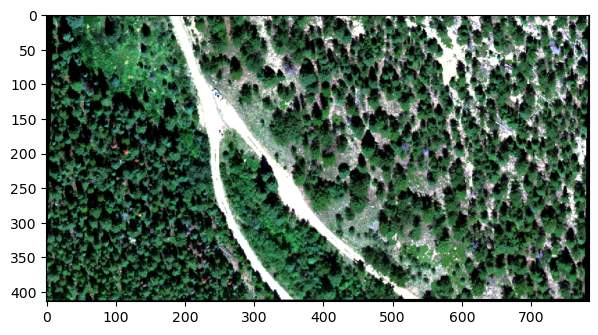

In [131]:
show_rgb(envi, correct= [])

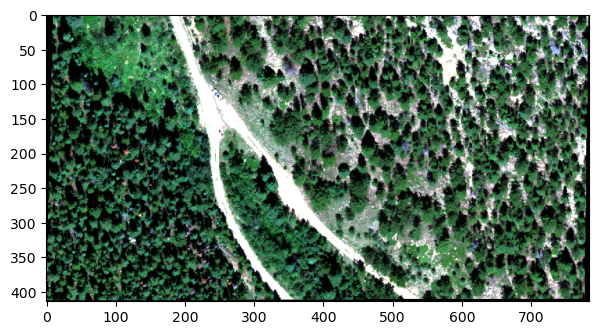

In [132]:
show_rgb(og_envi)

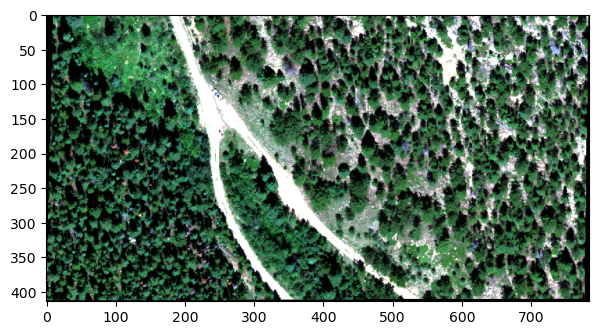

In [133]:
show_rgb(og_envi, correct = ['brdf'])

In [134]:
og_envi.get_wave(862, corrections= ['topo', 'brdf'])

memmap([[   0,    0,    0, ..., 3040, 8011,    0],
        [   0,    0,    0, ..., 2693, 6604,    0],
        [   0,    0,    0, ..., 4021, 8576,    0],
        ...,
        [8953, 7860, 8593, ...,    0,    0,    0],
        [8826, 8373, 8471, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0]], dtype=int16)

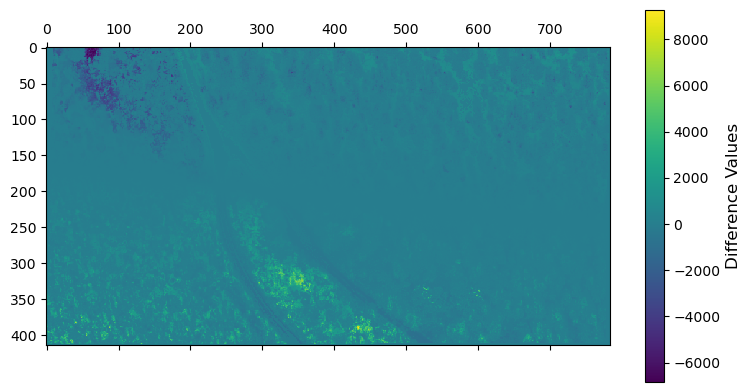

In [135]:
difference = (envi.get_wave(862)) - og_envi.get_wave(862)
plt.matshow(difference, cmap='viridis')  # 'viridis' is the default colormap in Matplotlib

# Add a colorbar to act as a legend for the values
cbar = plt.colorbar()
cbar.set_label('Difference Values', fontsize=12)  # Label for the colorbar

# Show the plot
plt.show()

In [136]:
envi.wavelengths

array([444., 475., 531., 560., 650., 668., 705., 717., 740., 862.])

In [137]:
corrected = envi.get_pixels([100],[300])
corrected


array([[1813.6772],
       [2119.6543],
       [2590.6125],
       [2992.0981],
       [3491.464 ],
       [3664.3015],
       [4280.1787],
       [4807.5547],
       [5272.0176],
       [6391.1714]], dtype=float32)

In [138]:
reflectance = corrected.flatten()
reflectance

array([1813.6772, 2119.6543, 2590.6125, 2992.0981, 3491.464 , 3664.3015,
       4280.1787, 4807.5547, 5272.0176, 6391.1714], dtype=float32)

In [139]:
og_envi2 = og_envi.get_pixels([100],[300])
og_envi2

array([[1800],
       [2112],
       [2561],
       [2949],
       [3413],
       [3580],
       [4174],
       [4695],
       [5136],
       [6238]], dtype=int16)

In [140]:
old_ref = og_envi2.flatten()
old_ref

array([1800, 2112, 2561, 2949, 3413, 3580, 4174, 4695, 5136, 6238],
      dtype=int16)

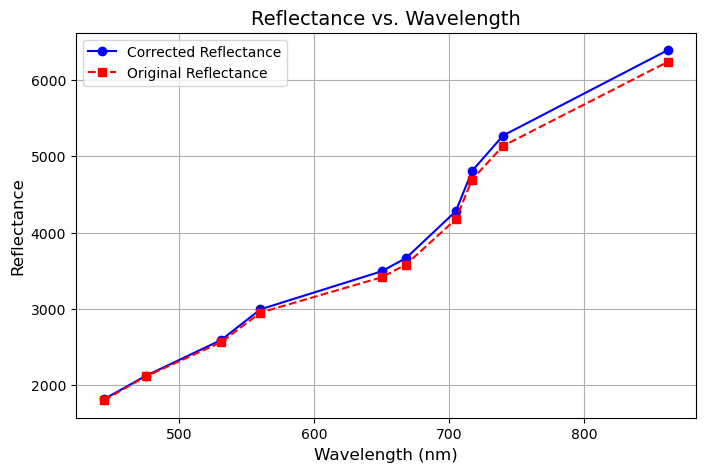

In [141]:
import matplotlib.pyplot as plt

# Create the figure and axes
plt.figure(figsize=(8, 5))  # Set figure size

# Plot both reflectance curves on the same graph
plt.plot(envi.wavelengths, reflectance, marker='o', linestyle='-', color='b', label='Corrected Reflectance')
plt.plot(envi.wavelengths, old_ref, marker='s', linestyle='--', color='r', label='Original Reflectance')

# Labels and title
plt.xlabel("Wavelength (nm)", fontsize=12)
plt.ylabel("Reflectance", fontsize=12)
plt.title("Reflectance vs. Wavelength", fontsize=14)

# Legend and grid
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
